In [27]:
import os
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from patsy import dmatrices
from pandas import Series
from matplotlib import pyplot
from datetime import datetime
from matplotlib.pyplot import figure
import statsmodels.tsa.api as smt
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

In [28]:
pwd()

'C:\\Users\\user\\Downloads\\Data sets'

In [29]:
os.chdir('C:\\Users\\user\\Downloads\\Data sets')

In [32]:
data = pd.read_csv("TractorSales.csv")
data.head(5)

,Month-Year,Number of Tractor Sold
0,3-Jan,141
1,3-Feb,157
2,3-Mar,185
3,3-Apr,199
4,3-May,203


In [3]:
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(data))

In [4]:
import calendar
data['Month'] = dates.month
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])
data['Year'] = dates.year

In [5]:
data.drop(['Month-Year'], axis=1, inplace=True)
data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
data = data[['Month', 'Year', 'Tractor-Sales']]

In [6]:
data.set_index(dates, inplace=True)

In [7]:
data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [8]:
# extract out the time-series
sales_ts = data['Tractor-Sales']

Text(0,0.5,'Tractor Sales')

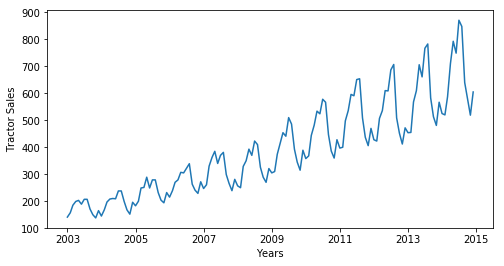

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

In [11]:
#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

Text(0.5,1,'Rolling Mean & Standard Deviation')

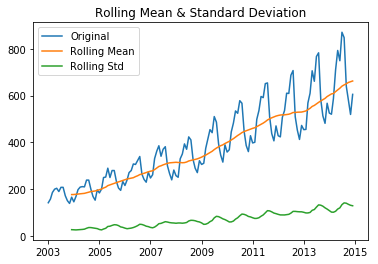

In [12]:
#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

Dickey-Fuller Test - Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [14]:
dftest = adfuller(sales_ts)
dftest

(1.1088250591467375,
 0.995291241524842,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1082.5357724796872)

Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

Results of Dickey-Fuller Test:
Test Statistic               
p-value                        
#Lags Used                     
Number of Observations Used    
Critical Value (5%)           -2.863355e+00
Critical Value (1%)           -3.434459e+00
Critical Value (10%)          -2.567736e+00
dtype: float64

Text(0,0.5,'Tractor Sales')

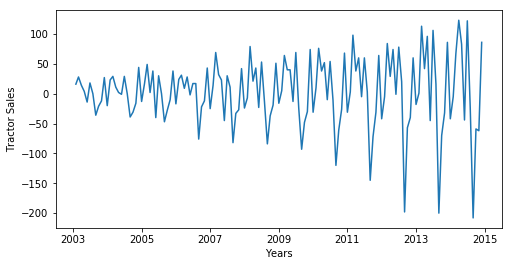

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Text(0,0.5,'Log (Tractor Sales)')

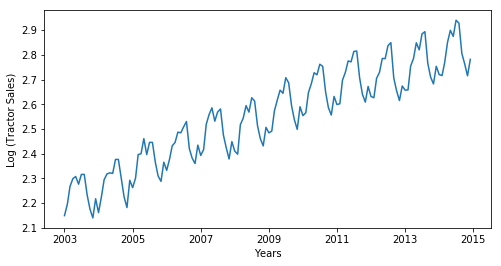

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')

Text(0,0.5,'Differenced Log (Tractor Sales)')

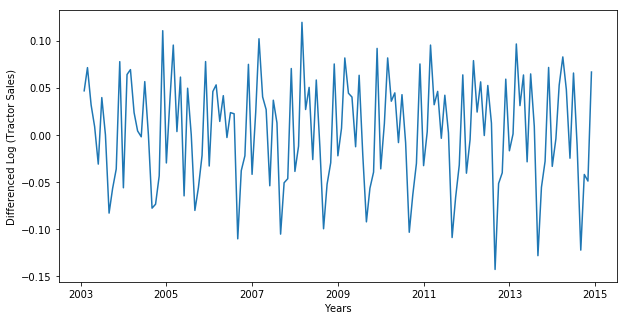

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

In [15]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

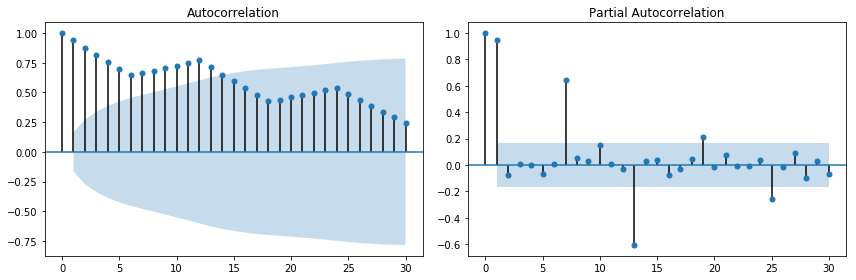

In [16]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log, lags=30, ax=axes[0])
smt.graphics.plot_pacf(sales_ts_log, lags=30, ax=axes[1])
plt.tight_layout()

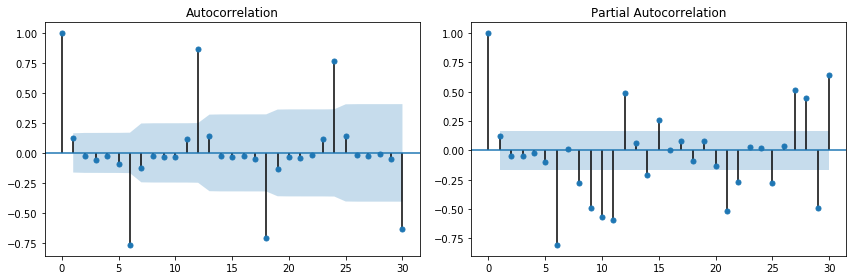

In [17]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1])
plt.tight_layout()

In [18]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [19]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [20]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [21]:
#Separate data into train and test
data['date'] = data.index
train = data[data.index < '2013-01-01']
test = data[data.index >= '2013-01-01']
train_sales_ts_log = np.log10(train['Tractor-Sales'])

In [22]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [23]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-600.0889088170553


The best fit model is selected based on Akaike Information Criterion (AIC) , and Bayesian Information Criterion (BIC) values. The idea is to choose a model with minimum AIC and BIC values.

Akaike Information Criterion (AIC) - AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

AIC=2K−2ln(L) 

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

As expected, our model has I (or integrated) component equal to 1. This represents differencing of order 1. There is additional differencing of lag 12 in the above best fit model. Moreover, the best fit model has MA value of order 1. Also, there is seasonal MA with lag 12 of order 1.

The model that we got here is different from the one that was discussed in the blog. Let us validate that model with ours how does that perform with statsmodel as well as our model.

## comparing our model with a random order model
param_order = (0, 1, 1)
param_seasonal_order = (0, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(sales_ts_log, order=param_order, 
                                  seasonal_order=param_seasonal_order,enforce_stationarity=True)
results = model.fit()
print("SARIMAX{}x{}12 model - AIC:{}".format(param_order, param_seasonal_order, results.aic))

## Predict sales on in-sample date using the best fit ARIMA model

In [28]:
best_model = sm.tsa.statespace.SARIMAX(train_sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True)
best_results = best_model.fit()

In [29]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 304.044
Date:                            Fri, 30 Nov 2018   AIC                           -600.089
Time:                                    11:24:19   BIC                           -588.972
Sample:                                01-01-2003   HQIC                          -595.575
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2948      0.079     -3.709      0.000      -0.451      -0.139
ar.S.L12       0.9917      0.007   

# comparing our model with a random order model

In [123]:
param_order = (0, 1, 1)
param_seasonal_order = (0, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(train_sales_ts_log, order=param_order, 
                                  seasonal_order=param_seasonal_order,enforce_stationarity=True)
results = model.fit()
print("SARIMAX{}x{}12 model - AIC:{}".format(param_order, param_seasonal_order, results.aic))

SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-568.1181244357285


In [30]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)


In [31]:
pred_dynamic_ci = pred_dynamic.conf_int()

In [32]:
pred99 = best_results.get_forecast(steps=24, alpha=0.1)

In [33]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['sales_ts_forecasted'] = np.power(10, pred99.predicted_mean)

In [34]:
testCopy

,Month,Year,Tractor-Sales,date,sales_ts_forecasted
2013-01-01,Jan,2013,454,2013-01-01,438.732042
2013-02-01,Feb,2013,455,2013-02-01,440.429556
2013-03-01,Mar,2013,568,2013-03-01,533.971053
2013-04-01,Apr,2013,610,2013-04-01,570.519455
2013-05-01,May,2013,706,2013-05-01,638.319723
2013-06-01,Jun,2013,661,2013-06-01,629.861782
2013-07-01,Jul,2013,767,2013-07-01,703.316960
2013-08-01,Aug,2013,783,2013-08-01,709.131007
2013-09-01,Sep,2013,583,2013-09-01,538.394906
2013-10-01,Oct,2013,513,2013-10-01,473.085665


In [35]:
# Compute the root mean square error
mse = ((testCopy['Tractor-Sales'] - testCopy['sales_ts_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 66.02


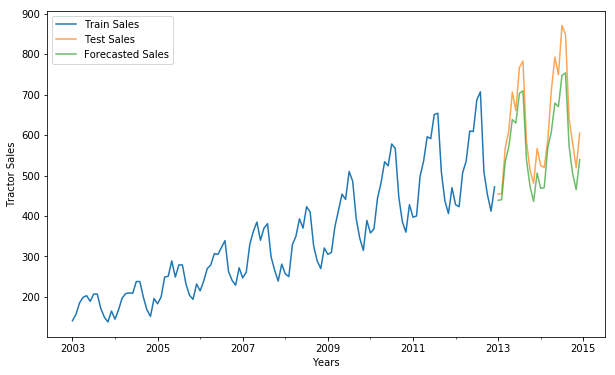

In [36]:
axis = train['Tractor-Sales'].plot(label='Train Sales', figsize=(10, 6))
testCopy['Tractor-Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['sales_ts_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

### Forecast sales using the best fit ARIMA model

In [37]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [38]:
n_steps = 36
idx = pd.date_range(data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,438.732042,407.769980,472.045061,407.769980,472.045061
2015-01-01,440.429556,402.702910,481.690567,402.702910,481.690567
2015-02-01,533.971053,481.537493,592.113989,481.537493,592.113989
2015-03-01,570.519455,508.274640,640.386954,508.274640,640.386954
2015-04-01,638.319723,562.454883,724.417336,562.454883,724.417336


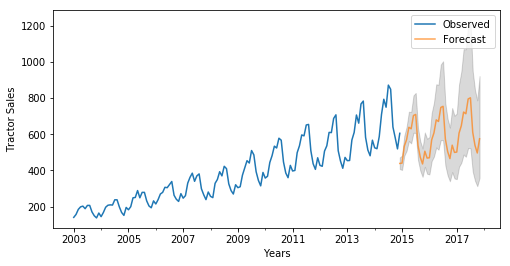

In [39]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(8, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

### Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

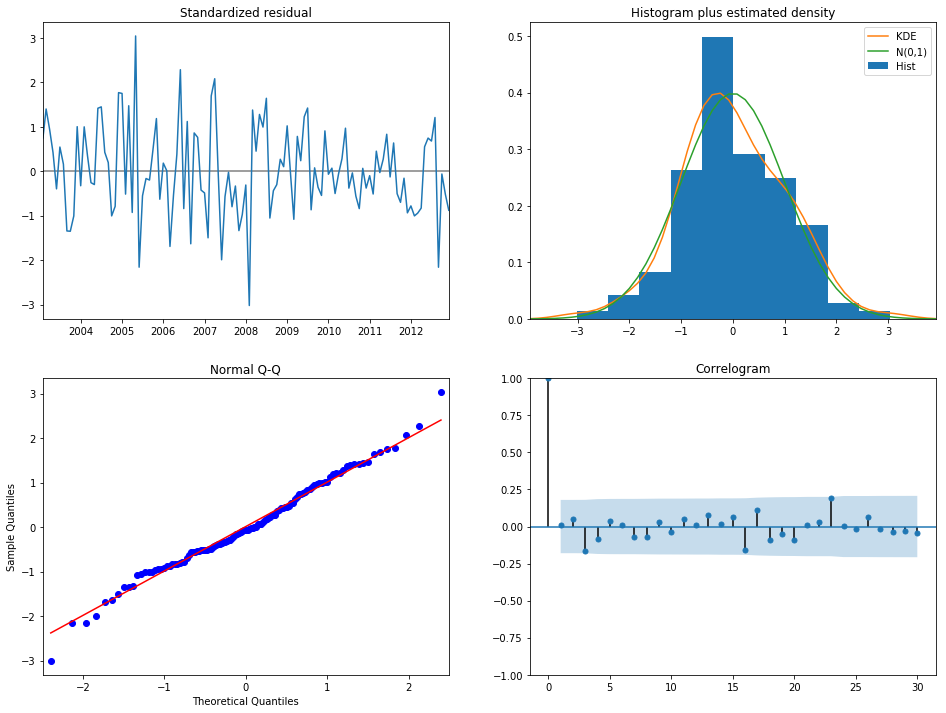

In [40]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

1. The KDE plot of the residuals on the top right is almost similar with the normal distribution.
2. The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
3. The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.